# EDA

### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm, tqdm_notebook

In [94]:
warnings.filterwarnings('ignore')
nlp = spacy.load("fr_core_news_md")
tqdm.pandas(tqdm_notebook)

### Database loading

In [ ]:
%%time
df = pd.read_pickle('../data/data.pkl')

### NaN

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67210 entries, 0 to 67209
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID              67210 non-null  object        
 1   NUMERO_AFFAIRE  59061 non-null  object        
 2   DATE_DEC        67210 non-null  datetime64[ns]
 3   NATURE          57570 non-null  object        
 4   SIEGE_APPEL     64240 non-null  object        
 5   CONTENU         67210 non-null  object        
 6   SCT             17098 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 3.6+ MB


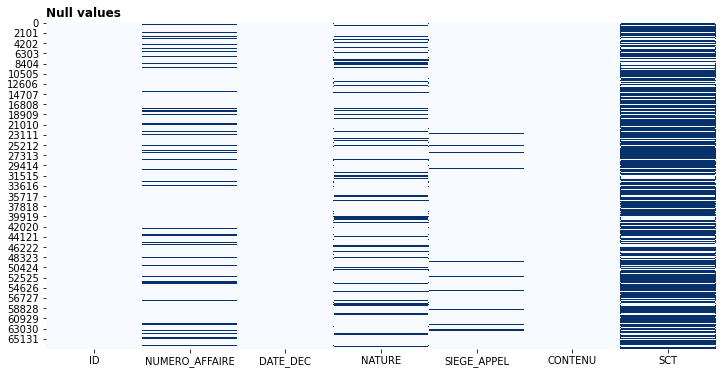

In [42]:
plt.figure(figsize = (12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="Blues")
plt.title('Null values', fontweight = 'bold', loc = 'left')
plt.show()

In [63]:
pd.DataFrame(round(df.isnull().sum() / len(df) * 100, 2), columns = ['% of NaN'])

,% of NaN
ID,0.00
NUMERO_AFFAIRE,12.12
DATE_DEC,0.00
NATURE,14.34
SIEGE_APPEL,4.42
CONTENU,0.00
SCT,74.56


### Duplicates

In [12]:
df.ID.duplicated().sum()

0

### Time distribution

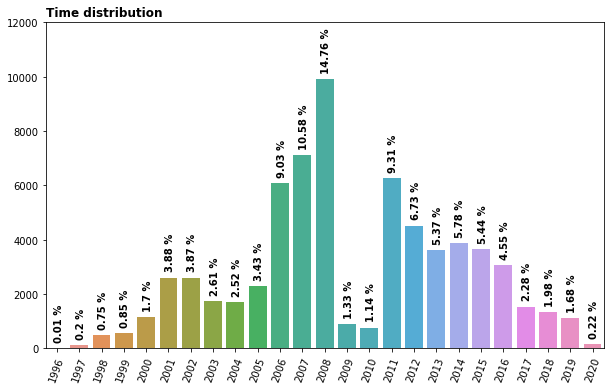

In [69]:
plt.figure(figsize = (10, 6))
sns.barplot(x = df.groupby(df.DATE_DEC.dt.year).count().index,
            y = df.groupby(df.DATE_DEC.dt.year).count()['ID'].values)

for i in range(len(df.DATE_DEC.dt.year.unique())):
    plt.text(x = i - 0.15,
             y = df.groupby(df.DATE_DEC.dt.year).count().ID.values[i] + 300,
             s = f'{round(df.groupby(df.DATE_DEC.dt.year).count().ID.values[i] / len(df) * 100, 2)} %',
             fontweight = 'bold',
             rotation = 90)
    
plt.xlabel(None)
plt.gca().set_ylim([0,12000])
plt.title('Time distribution', loc = 'left', fontweight = 'bold')
plt.xticks(rotation =70)
plt.show()

### Nature of decisions

In [53]:
df.NATURE.value_counts().values.sum()

57570

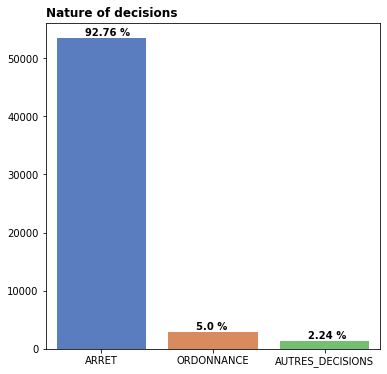

In [79]:
plt.figure(figsize = (6,6))

sns.countplot(df.NATURE, palette = 'muted')
for i in range(len(df.NATURE.value_counts())):
    plt.text(x = i - 0.15, y = df.NATURE.value_counts().values[i] + 500, 
             s = f'{round(df.NATURE.value_counts().values[i] / df.NATURE.value_counts().values.sum() * 100, 2)} %', fontweight = 'bold')
plt.ylabel(None)
plt.xlabel(None)
plt.title('Nature of decisions', fontweight = 'bold', loc = 'left')
plt.show()

### Spatial distribution

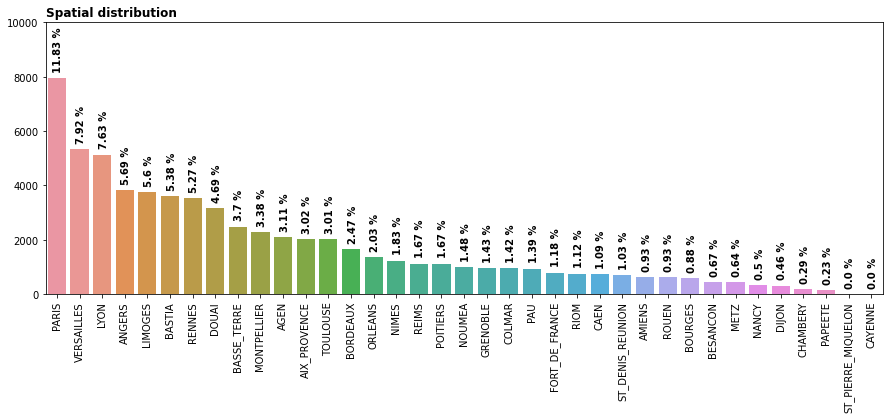

In [85]:
plt.figure(figsize = (15,5))

sns.countplot(df.SIEGE_APPEL, order = df.SIEGE_APPEL.value_counts().index)

for i in range(len(df.SIEGE_APPEL.value_counts())):
    plt.text(x = i - 0.15,
             y = df.SIEGE_APPEL.value_counts().values[i] + 300,
             s = f'{round(df.SIEGE_APPEL.value_counts().values[i] / len(df) * 100, 2)} %',
             fontweight = 'bold',
             rotation = 90)
    
plt.xticks(rotation = 90)
plt.ylabel(None)
plt.xlabel(None)
plt.title('Spatial distribution', fontweight = 'bold', loc ='left')
plt.gca().set_ylim([0,10000])
plt.show()

In [117]:
label_corpus, label_counter = freq_counter(df.label_tokens[df.label_tokens.notnull()])

In [121]:
wordcloud = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(' '.join(label_corpus))                                                                          

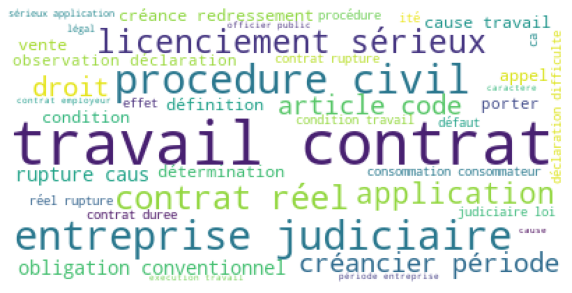

In [124]:
plt.figure(figsize = (10, 15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [125]:
label_counter.most_common(20)

[('contrat', 3168),
 ('travail', 2790),
 ('condition', 1932),
 ('entreprise', 1630),
 ('civil', 1495),
 ('application', 1480),
 ('difficulte', 1333),
 ('rupture', 1256),
 ('judiciaire', 1195),
 ('responsabilité', 1103),
 ('obligation', 1098),
 ('action', 1067),
 ('loi', 931),
 ('execution', 922),
 ('règle', 895),
 ('bail', 886),
 ('licenciement', 885),
 ('redressement', 836),
 ('général', 828),
 ('procedure', 769)]

#### Bigram

In [126]:
df['label_tokens_join'] = df.label_tokens[df.label_tokens.notnull()].apply(lambda x: ' '.join(x))

In [128]:
vec = CountVectorizer(lowercase = False, ngram_range=(2, 2))
BOW = vec.fit_transform(df.label_tokens_join[df.label_tokens_join.notnull()]).toarray()
bow_df = pd.DataFrame(data=BOW, columns=vec.get_feature_names())

In [132]:
bow_df.sum(axis = 0).sort_values(ascending=False).head(20)

contrat travail            2567
entreprise difficulte      1419
travail rupture            1206
rupture licenciement        873
redressement judiciaire     792
procedure civil             742
règle général               683
travail execution           677
protection consommateur     561
difficulte redressement     547
période observation         500
judiciaire période          488
réel sérieux                449
article code                434
domaine application         423
securite social             418
loi juillet                 408
cause réel                  391
difficulte loi              384
caus cause                  384
dtype: int64

In [133]:
bow_sum = bow_df.sum(axis = 0).sort_values(ascending=False).head(20)

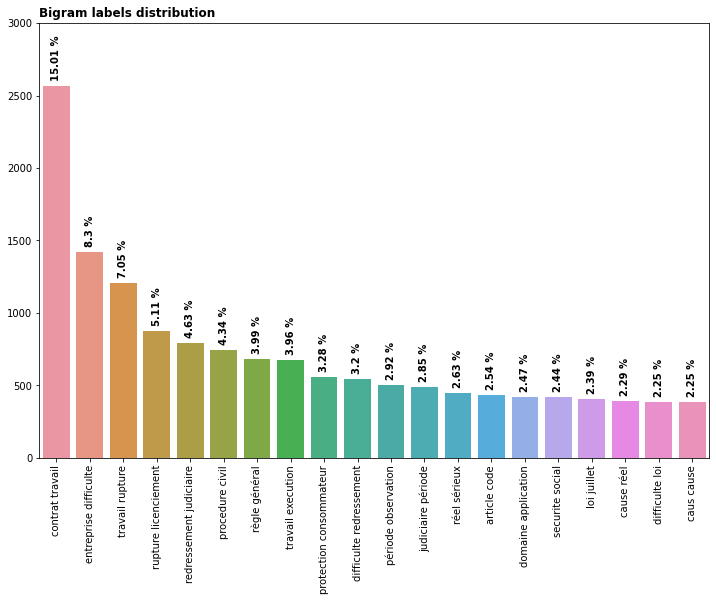

In [159]:
plt.figure(figsize = (12, 8))

sns.barplot(x = bow_sum.index, y = bow_sum.values)
for i in range(20):
    plt.text(x = i - 0.15, 
             y = bow_sum.values[i] + 50,
             s = f'{round(bow_sum.values[i]/170.98, 2)} %',
             fontweight = 'bold',
             rotation = 90)
plt.xticks(rotation = 90)
plt.gca().set_ylim([0, 3000])
plt.title('Bigram labels distribution', fontweight = 'bold', loc = 'left')
plt.show()